In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
if 'changed' not in globals():
    os.chdir("..")
    os.chdir("..")
    global changed
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import SR_hetro as srh

In [2]:
config_paths ={
    'Denmark_F_1890':"configs/HUMANS/configs_Denmark_F_1890",
    'Denmark_F_1900':"configs/HUMANS/configs_Denmark_F_1900",
    'Sweden_F_1910':"configs/HUMANS/configs_Sweden_F_1910_hetro",
}
thresholds = {
    'Denmark_F_1890':94,
    'Denmark_F_1900':93,
    'Sweden_F_1910':70,
}
apply_thresh = True
scale =365
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())
results_path = 'results_csvs/humans_F_combined.csv'
data_key = 'Sweden_F_1910'


In [3]:
configs = {}
for key in config_paths.keys():
    configs[key] = cl.read_configs(config_paths[key])

submission_folders={}
h5_paths = {}
data_files ={}
for key in configs.keys():
    index = int(configs[key].get('DEFAULT', 'index'))
    submission_folder = configs[key].get(f'SUBMISSION_{index-1}', 'submission_folder')
    submission_folder = submission_folder.split(current_folder)[-1]
    submission_folder = submission_folder[1:]
    submission_folders[key] = submission_folder
    data_file = configs[key].get('DEFAULT', 'data_file')
    data_file = data_file.split(current_folder)[-1]
    data_file = data_file[1:]
    data_files[key] = data_file
    h5_paths[key] = os.path.join(submission_folders[key],'h5_files') 



ds = dtds.dsFromFile(data_files[data_key])


In [4]:
samples_trans0 = {}
lnprobs0 = {}
for key in configs.keys():
    samples_trans0[key], lnprobs0[key] = srmc.loadSamplesFromDir(h5_paths[key], best=False, thin =5, discard=200)

In [5]:
for key in samples_trans0.keys():
    print(key)
    print(samples_trans0[key].shape)

Denmark_F_1890
(4996610, 5)
Denmark_F_1900
(4986550, 5)
Sweden_F_1910
(3982890, 5)


In [6]:
samples_trans = {}
lnprobs = {}
if apply_thresh:
    for key in configs.keys():
        thresh = np.percentile(lnprobs0[key],thresholds[key] )
        samples_trans[key] = samples_trans0[key][lnprobs0[key]>thresh]
        lnprobs[key] = lnprobs0[key][lnprobs0[key]>thresh]

for key in samples_trans.keys():
    samples_trans[key] = samples_trans[key][np.argsort(lnprobs[key])]
    lnprobs[key] = lnprobs[key][np.argsort(lnprobs[key])]

In [7]:
for key in samples_trans.keys():
    print(key)
    print(samples_trans[key].shape)

Denmark_F_1890
(299505, 5)
Denmark_F_1900
(349044, 5)
Sweden_F_1910
(1194700, 5)


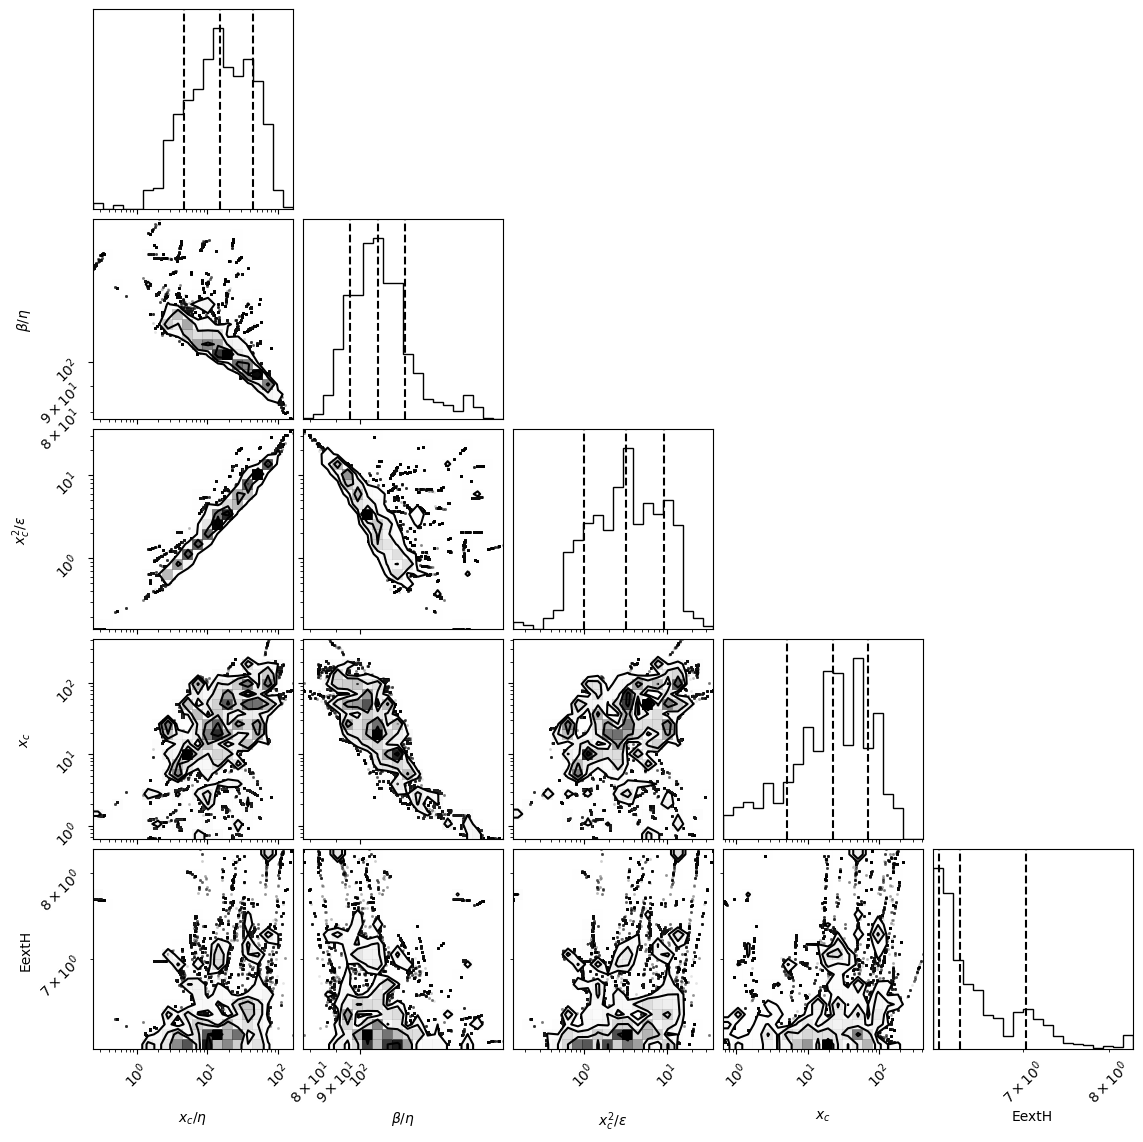

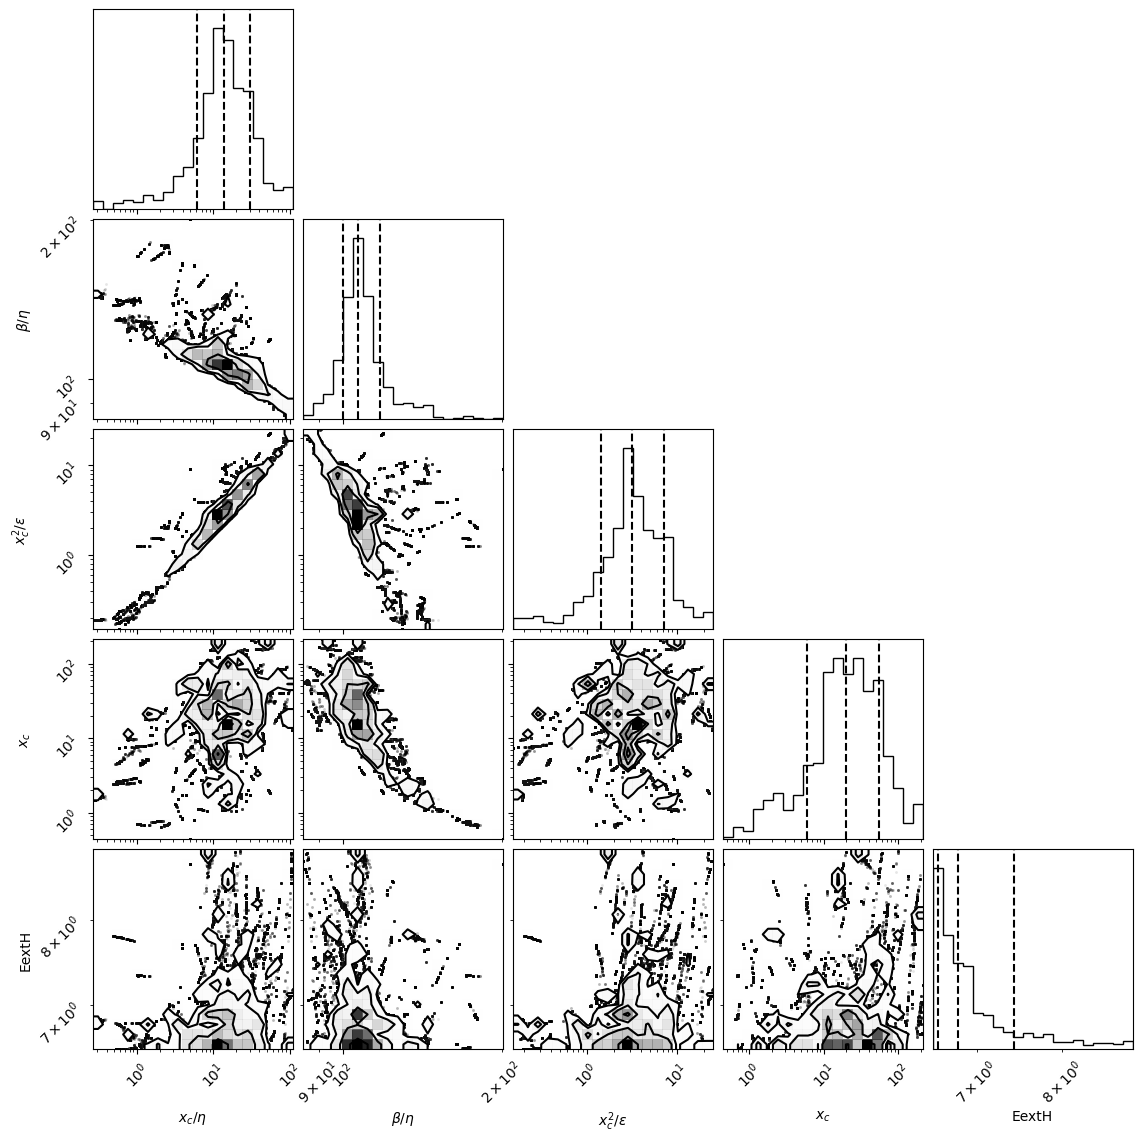

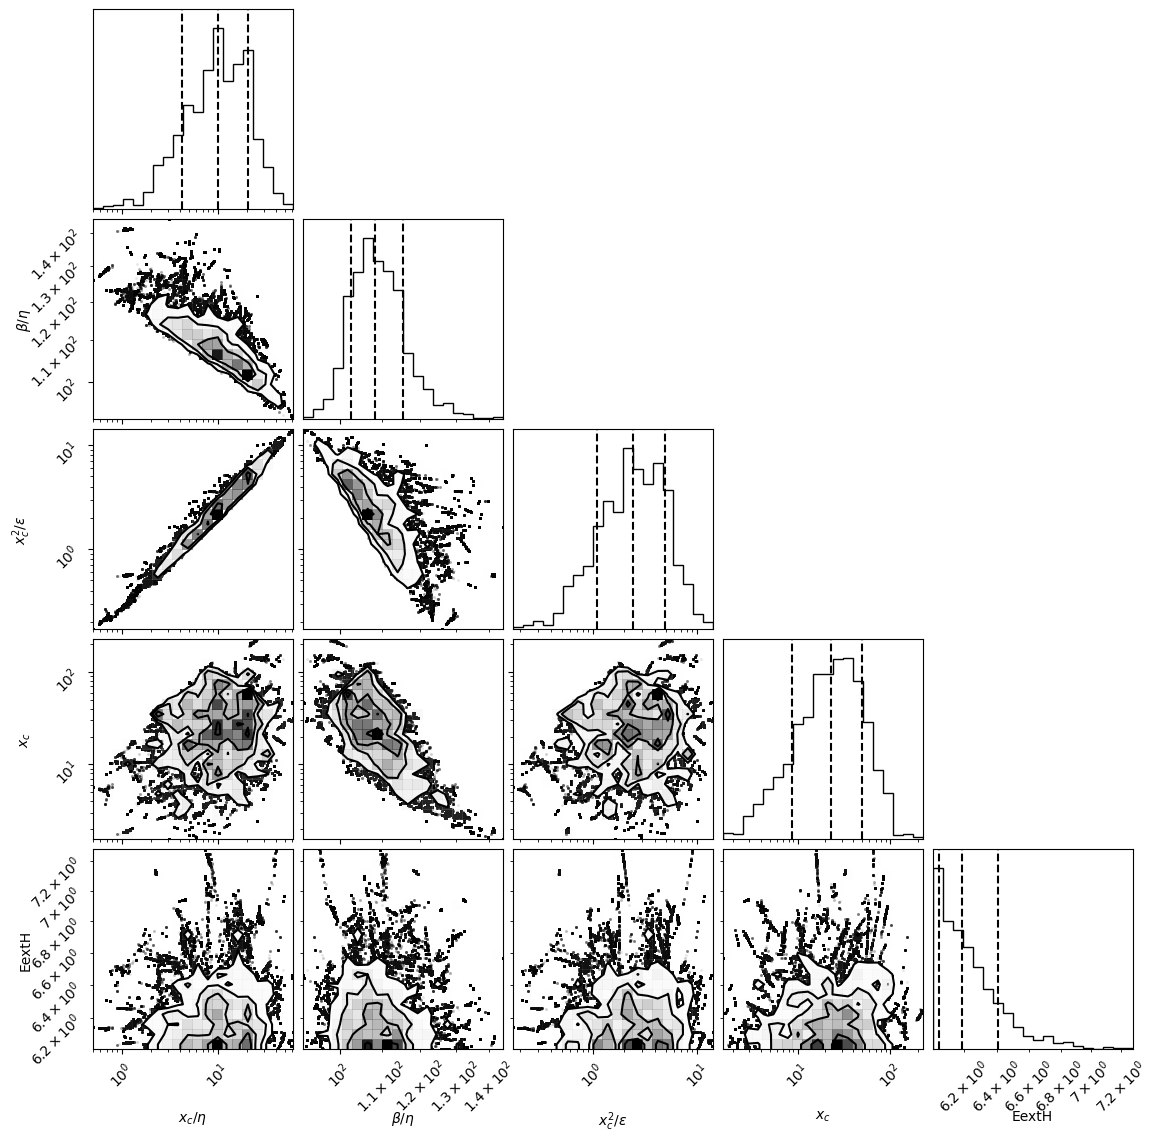

In [8]:
nruns = len(samples_trans.keys())
# fig, ax = plt.subplots(nruns,1, figsize=(10,10*nruns))
for key in samples_trans.keys():
    corner.corner(samples_trans[key], labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","EextH"], axes_scale='log',quantiles=[0.16, 0.5, 0.84])

In [63]:
if False:
    from SRtools import samples_utils as ssu
    from SRtools import config_lib as ccl
    config_dict = None
    path1 = "HUMANS/humans_F_combined.csv"
    post_path = os.path.join('posterior_csvs',path1.replace('.csv','_post.csv'))

    help_text ="run from baysian01, from joint posterior"

    post2 = ssu.JointPosterior(list(samples_trans.values()), list(lnprobs.values()), 100, log=True,config_params=config_dict,help_text=help_text,prior=None)
    post2.save_to_file(post_path)


Processing unique samples for set 2: 100%|██████████| 9649/9649 [00:00<00:00, 495935.78it/s]


In [56]:
import samples_utils as su
post = su.JointPosterior(list(samples_trans.values()), list(lnprobs.values()), bins = 100,log=True)

Processing unique samples for set 2: 100%|██████████| 9649/9649 [00:00<00:00, 501267.56it/s]


In [54]:
post.evidence

-83102.51067380699

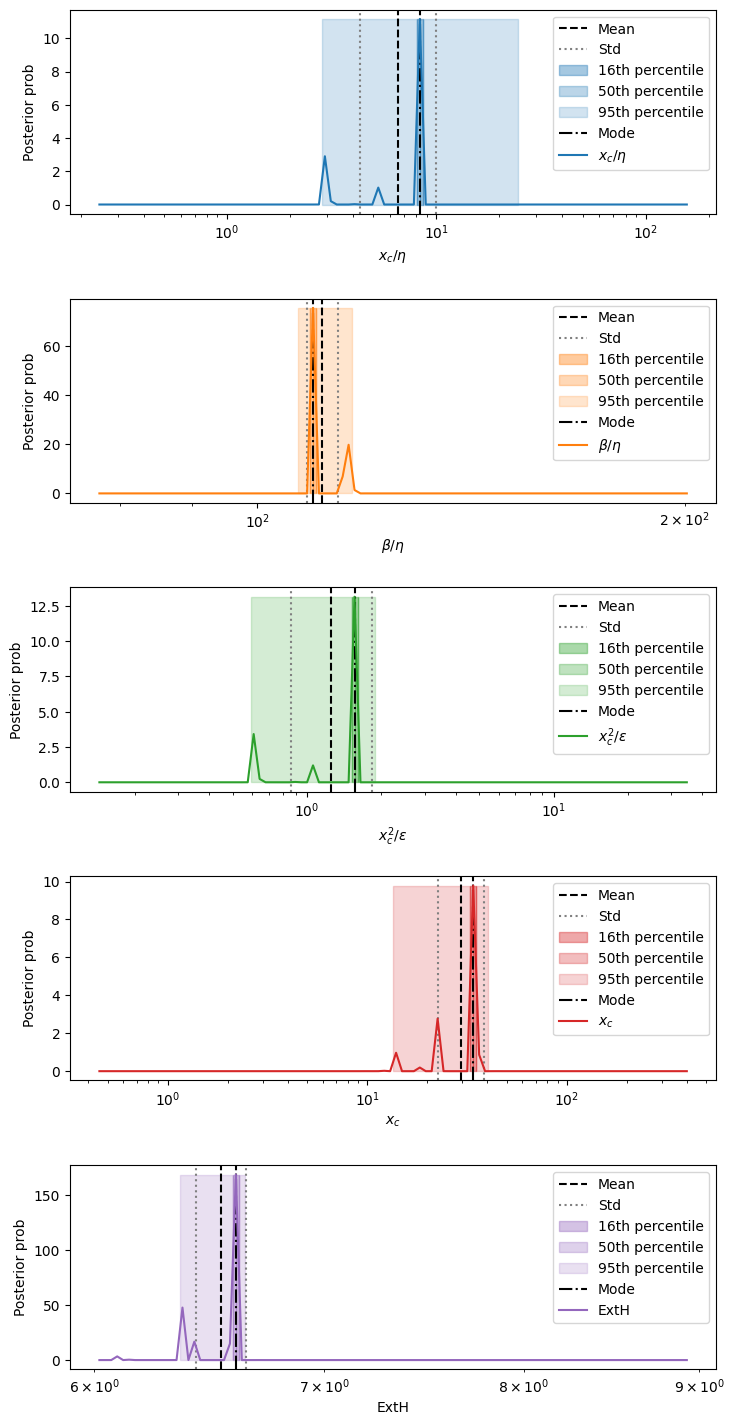

In [57]:
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"],scale='log')

In [61]:
path_days = f"{results_path.split('.csv')[0]}_days.csv" if results_path is not None else None
df=post.create_posterior_df(filepath=results_path, ds = [ds], ds_labels=['data'])
df_days=post.create_posterior_df(filepath=path_days, ds = [ds], ds_labels=['data'],rescale=scale)

Processing unique samples for set 2: 100%|██████████| 9584/9584 [00:00<00:00, 522971.57it/s]


Rescaling the samples TIME by 365


Processing unique samples for set 2: 100%|██████████| 9577/9577 [00:00<00:00, 499948.34it/s]


In [62]:
display(df)

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,6.536,"[3.399, 2.236]",3.13,"[3.029, 3.233]","[3.029, 3.233]","[2.658, 3.684]",3.057
beta/eta,111.13,"[2.807, 2.738]",115.968,"[115.411, 116.527]","[115.411, 117.654]","[114.306, 118.791]",117.061
xc^2/epsilon,1.253,"[0.574, 0.394]",0.946,"[0.92, 0.972]","[0.87, 1.028]","[0.624, 1.086]",0.631
xc,29.486,"[9.017, 6.905]",21.058,"[20.349, 21.791]","[20.349, 23.336]","[17.745, 24.989]",18.489
ExtH,6.532,"[0.111, 0.109]",6.366,"[6.353, 6.378]","[6.353, 6.378]","[6.303, 6.404]",6.093
eta,6.432,"[2.25, 1.667]",2.711,"[2.624, 2.802]","[2.457, 2.802]","[2.155, 3.194]",6.049
beta,734.874,"[272.434, 198.752]",305.348,"[295.838, 315.164]","[277.698, 357.686]","[88.897, 924.14]",708.088
epsilon,780.035,"[236.633, 181.556]",160.515,"[149.946, 171.828]","[149.946, 196.904]","[44.005, 881.063]",542.144
sqrt(xc/eta),1.961,"[0.494, 0.395]",1.769,"[1.74, 1.798]","[1.74, 1.798]","[1.63, 1.858]",1.748
s= eta^0.5*xc^1.5/epsilon,0.395,"[0.0863, 0.0709]",0.475,"[0.468, 0.482]","[0.454, 0.482]","[0.44, 0.529]",0.361


In [12]:
display(df)

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,7.461,0.269,5.884,"[5.078, 6.691]","[5.078, 6.691]","[3.464, 8.304]",3.057
beta/eta,108.914,0.864,116.203,"[115.586, 116.821]","[114.35, 116.821]","[108.175, 118.056]",117.061
xc^2/epsilon,1.721,0.101,1.38,"[1.203, 1.558]","[1.203, 1.558]","[0.849, 1.912]",0.631
xc,35.086,3.49,18.953,"[16.896, 21.01]","[16.896, 21.01]","[12.782, 29.238]",18.489
ExtH,6.609,0.038,6.32,"[6.306, 6.335]","[6.277, 6.335]","[6.277, 6.393]",6.093
eta,5.7,1.798,8.636,"[8.554, 8.718]","[8.39, 8.718]","[3.961, 9.047]",6.049
beta,645.717,221.629,1720.227,"[1694.341, 1728.856]","[1642.569, 1728.856]","[279.227, 1728.856]",708.088
epsilon,802.633,356.529,612.052,"[524.619, 699.485]","[349.753, 699.485]","[0.0215, 874.35]",542.144
sqrt(xc/eta),2.282,0.581,2.016,"[1.955, 2.077]","[1.955, 2.2]","[1.833, 2.811]",1.748
s= eta^0.5*xc^1.5/epsilon,0.467,0.0936,0.484,"[0.465, 0.504]","[0.465, 0.542]","[0.426, 0.581]",0.361
